<a href="https://colab.research.google.com/github/DmitrijLeontev/Dmitrij_Leontev/blob/main/Stajirovki-rosstandart/Prototip3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подход 3

Тестируем RAG (англ. Retrieval Augment Generation) с использованием GigaChat на примере "разговор с книгой".

Пример взят с Github по ссылке из документации к GigaChat:

https://github.com/ai-forever/gigachain/tree/master

Retrieval Augmented Generation(RAG) с использованием GigaChat на примере задачи "разговор с книгой"

Подход RAG позволяет большим языковым моделям (LLM) отвечать на вопросы по документам, которы не помещаются в промпт. Ниже приведен пример того, как можно научить модель отвечать на вопросы, используя текст из книги "Мастер и Маргарита".

Подробнее про RAG вы можете прочитать в документации LangChain и в курсе по промпт-инженирингу от Сбера (ссылка будет позже).

В качестве примера мы рассмотрим текст романа Булгакова "Мастер и Маргарита" (главы 1 и 2).

Вопрос будет - Какой плащ был у Понтия Пилата?. Ответ содержится во второй главе книги: В белом плаще с кровавым подбоем, шаркающей кавалерийской походкой, ранним утром четырнадцатого числа весеннего месяца нисана в крытую колоннаду между двумя крыльями дворца ирода великого вышел прокуратор Иудеи Понтий Пилат.
Попытка совмещения двух ноутбуков:

1). Retrieval Augmented Generation(RAG) с использованием GigaChat на примере задачи "разговор с книгой"

2).ДЗPro6(9)занятиес.ipynb из курса ChatGPTProfessional

Установка

Для работы нам понадобится векторая база данных. Мы будем использовать Chroma.

In [ ]:
!pip install chromadb --quiet

In [ ]:
import chromadb

Инициализация модели

Теперь инициализируем модель GigaChat.

In [ ]:
!pip install gigachain

In [ ]:
!pip install gigachat

In [ ]:
from langchain.chat_models.gigachat import GigaChat

llm = GigaChat(credentials="OTQ0YThiZTgtNTdjYy00NDIxLWFkNGMtMDcxN2I1YmJiZTk3OjdiM2Q0MGVkLTAzZDMtNGVmMy1iZjk1LTQ1YzZjM2FhMTRkYQ==", verify_ssl_certs=True)

In [ ]:
# Передайте полученные авторизационные данные в параметре credentials объекта GigaChat

!chat = GigaChat(credentials='OTQ0YThiZTgtNTdjYy00NDIxLWFkNGMtMDcxN2I1YmJiZTk3OjdiM2Q0MGVkLTAzZDMtNGVmMy1iZjk1LTQ1YzZjM2FhMTRkYQ==')

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `chat = GigaChat(credentials='OTQ0YThiZTgtNTdjYy00NDIxLWFkNGMtMDcxN2I1YmJiZTk3OjdiM2Q0MGVkLTAzZDMtNGVmMy1iZjk1LTQ1YzZjM2FhMTRkYQ==')'


In [ ]:
# Вы также можете явно указать версию API с помощью атрибута scope:
# Личное пространство
!giga = GigaChat(credentials='OTQ0YThiZTgtNTdjYy00NDIxLWFkNGMtMDcxN2I1YmJiZTk3OjdiM2Q0MGVkLTAzZDMtNGVmMy1iZjk1LTQ1YzZjM2FhMTRkYQ==', scope="GIGACHAT_API_PERS")

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `giga = GigaChat(credentials='OTQ0YThiZTgtNTdjYy00NDIxLWFkNGMtMDcxN2I1YmJiZTk3OjdiM2Q0MGVkLTAzZDMtNGVmMy1iZjk1LTQ1YzZjM2FhMTRkYQ==', scope="GIGACHAT_API_PERS")'


Установка сертификатов минцифры

Для обращения к GigaChat в вашем приложении или в вашей ОС должны быть установлены сертификаты минцифры.

Вы можете установить сертификаты с помощью утилиты gigachain-cli. Для этого:

Установите утилиту с помощью менеджера пакетов pip:

In [ ]:
!pip install gigachain-cli

Установите сертификаты с помощью команды:

In [ ]:
!gigachain install-rus-certs

ERR: Сертификат Минцифры уже установлен!


In [ ]:
# Подгружаем гугл-диск. Там лежит Мастер и Маргарита

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Для проверки спросим у модели вопрос про цвет плаща без какого-либо контекста. Возможно, она и так будет давать ожидаемый ответ...

In [ ]:
from langchain.schema import HumanMessage

question = "Какой плащ был у Понтия Пилата?"
llm([HumanMessage(content=question)]).content[0:200]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
Понтий Пилат, римский прокуратор Иудеи, носил плащ, который назывался "тога". Тога была традиционной одеждой римлян и представляла собой длинное прямоугольное полотно ткани, которое оборачивалось вокр

Видим, что модель не отвечает так, как нам хотелось бы, поэтому применим RAG-подход.

Подготовка документа Для работы с документом нам нужно разделить его на части. Для этого используем TextLoader для загрузки книги и RecursiveCharacterTextSplitter, чтобы разделить текст на приблизительно равные куски в ~1000 символов с перекрытием в ~200 символов. Этот тип сплиттера сам выбирает каким способом следует оптимально разделять документ (по абзацам, по предложениям и т.д.)

In [ ]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Указание кодировки cp1251 при открытии файла
file_path = "/content/drive/MyDrive/Colab Notebooks/stagirovki/Разработка_нейро_консультанта_для_обработки_обращений_граждан_в_федеральные_органы_исполнительной_власти _ФГБУ_ВНИИМС_Росстандарт/Булгаков Михаил. Мастер и Маргарита (Художник Г. Новожилов) - royallib.com.txt"
loader = TextLoader(file_path=file_path, encoding='cp1251')

documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)
documents = text_splitter.split_documents(documents)

print(f"Total documents: {len(documents)}")

Total documents: 1005


После нарезки мы получили 1005 документов частями книги.

Создание базы данных эмбеддингов

Эмбеддинг это векторное представление текста, которое может быть использовано для определения смысловой близости текстов. Векторная база данных хранит тексты и соответствующие им эмбеддинги, а также умеет выполнять поиск по ним. Для работы с базой данных мы создаем объект GigaChatEmbeddings и передаем его в базу данных Chroma.

Обратите внимание, что сервис для вычисления эмбеддингов может тарифицироваться отдельно от стоимости модели GigaChat.

Напишу сразу, оплату эмбеддингов произвел отдельно для доступа к векторному хранилищу и модели GigaChatEmbeddings: затраты Сбером заявлены в пределах 1000 рублей на 6 месяцев , дают 10000 токенов.

In [ ]:
from chromadb.config import Settings
from langchain.vectorstores import Chroma
from langchain_community.embeddings.gigachat import GigaChatEmbeddings

embeddings = GigaChatEmbeddings(
    credentials="OTQ0YThiZTgtNTdjYy00NDIxLWFkNGMtMDcxN2I1YmJiZTk3OjdiM2Q0MGVkLTAzZDMtNGVmMy1iZjk1LTQ1YzZjM2FhMTRkYQ==", verify_ssl_certs=True
)

db = Chroma.from_documents(
    documents,
    embeddings,
    client_settings=Settings(anonymized_telemetry=False),
)

In [ ]:
import os
import getpass
import matplotlib.pyplot as plt
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage
import re
import tiktoken
import requests
import openai
from langchain.docstore.document import Document

In [ ]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [ ]:
# База знаний, которая будет подаваться в langChain
database= load_document_text('https://docs.google.com/document/d/1PGw2Y4PSJ2S7vfPlge9j6G_x0zX6jX4UEIitfwlP-c0/edit?usp=sharing')   # заполните необходимым значением, база данных

In [ ]:
database[:1000]

'\ufeff# УТВЕРЖДЕН:\r\nПостановлением Исполкома\r\nОбщероссийской общественной организации\r\n«Российский футбольный союз»\r\n№ 65/2 от «23» декабря 2010 года\r\nс последующими изменениями и дополнениями\r\n(в редакции на 01.10.2019)\r\n# ДИСЦИПЛИНАРНЫЙ РЕГЛАМЕНТ РФС\r\nМосква, 2019 год\r\nСписок терминов и определений\r\nВ настоящем Регламенте используются следующие термины и определения:\r\n1. ФИФА – Международная федерация футбольных ассоциаций.\r\n2. УЕФА – Союз европейских футбольных ассоциаций.\r\n3. РФС – Общероссийская общественная организация «Российский футбольный\r\nсоюз».\r\n4. РФПЛ – Некоммерческое партнерство «Российская футбольная Премьер-Лига».\r\n5. ФНЛ – Некоммерческое партнерство «Футбольная Национальная Лига».\r\n6. Юрисдикционные органы – Контрольно-дисциплинарный комитет РФС,\r\nАпелляционный комитет РФС, осуществляющие свою деятельность в соответствии с\r\nуставом РФС и настоящим Регламентом, а также юрисдикционные органы Федераций,\r\nосуществляющие свою деятель

In [ ]:
# предобработаем текст таким образом, чтобы его можно было бы поделить на чанки при помощи MarkdownHeaderTextSplitter
def text_to_markdown(text):
    # Добавляем заголовок 1 уровня на основе римских чисел (без переноса строки)
    # и дублируем его строчкой ниже - иначе эта информация перенесется в метаданные, а порой она бывает полезной.
    def replace_header1(match):
        return f"# {match.group(2)}\n{match.group(2)}"
    '''Далее используем функцию re.sub из модуля регулярных выражений re для замены подстрок в строке text.
    Шаблон регулярного выражения (I{1,3}|IV|V)\. (.+) ищет римские числа от I до V в начале строки, за которыми следует точка и пробел.
    Функция replace_header1 вызывается для каждого совпадения, и ее возвращаемое значение используется для замены найденной подстроки.
    Флаг re.M позволяет ^ соответствовать началу каждой строки, а не только началу всего текста.'''
    text = re.sub(r'^(I{1,3}|IV|V)\. (.+)', replace_header1, text, flags=re.M)

    # Добавляем текст, выделенный жирным шрифтом (он заключен между *)
    # и дублируем его строчкой ниже
    def replace_header2(match):
        return f"## {match.group(1)}\n{match.group(1)}"

    text = re.sub(r'\*([^\*]+)\*', replace_header2, text)

    return text

In [ ]:
markdown = text_to_markdown(database)                 # заполните необходимым значением
print(markdown[:30000])

﻿# УТВЕРЖДЕН:
Постановлением Исполкома
Общероссийской общественной организации
«Российский футбольный союз»
№ 65/2 от «23» декабря 2010 года
с последующими изменениями и дополнениями
(в редакции на 01.10.2019)
# ДИСЦИПЛИНАРНЫЙ РЕГЛАМЕНТ РФС
Москва, 2019 год
Список терминов и определений
В настоящем Регламенте используются следующие термины и определения:
1. ФИФА – Международная федерация футбольных ассоциаций.
2. УЕФА – Союз европейских футбольных ассоциаций.
3. РФС – Общероссийская общественная организация «Российский футбольный
союз».
4. РФПЛ – Некоммерческое партнерство «Российская футбольная Премьер-Лига».
5. ФНЛ – Некоммерческое партнерство «Футбольная Национальная Лига».
6. Юрисдикционные органы – Контрольно-дисциплинарный комитет РФС,
Апелляционный комитет РФС, осуществляющие свою деятельность в соответствии с
уставом РФС и настоящим Регламентом, а также юрисдикционные органы Федераций,
осуществляющие свою деятельность в соответствии с настоящим регламентом, уставами
и иными док

In [ ]:
# Инструкция в system
system = load_document_text('https://docs.google.com/document/d/16GKwLjPg3EpfIG_iHL3YWmGPS0A0NBhER7gBNGSIK5A/edit?usp=sharing') # заполните параметр ссылкой на составленный вами промпт. Не забудьте открыть доступ

In [ ]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    plt.hist(fragment_token_counts, bins=20, alpha=0.5, label='Fragments')
    plt.title('Distribution of Fragment Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=0,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )

    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]

    # Подсчет токенов для каждого source_chunk и построение графика
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]
    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    plt.title('Distribution of Source Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    return source_chunks

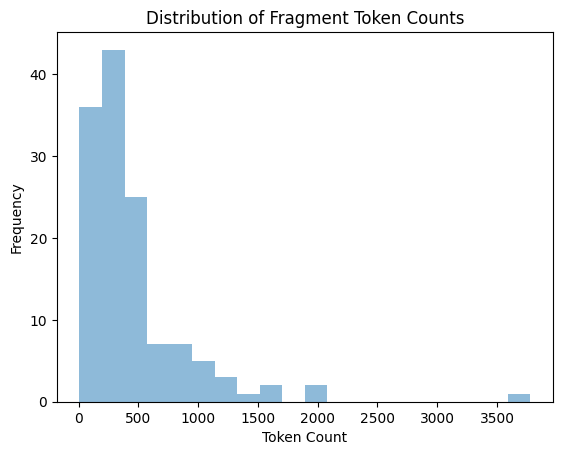

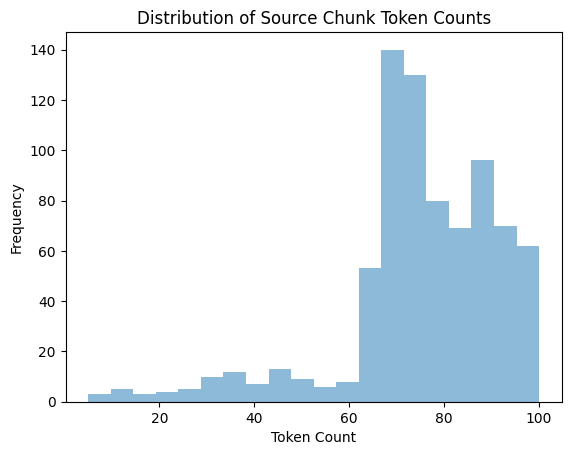

Общее количество чанков:  785
Первый чанк  page_content='\ufeff# УТВЕРЖДЕН:\nПостановлением Исполкома\nОбщероссийской общественной организации\n«Российский футбольный союз»\n№ 65/2 от «23» декабря 2010 года\nс последующими изменениями и дополнениями' metadata={}


In [ ]:
source_chunks = split_text(database, 100)                          # заполните необходимыми значениями
print("Общее количество чанков: ",len(source_chunks))
print("Первый чанк ", source_chunks[0])

In [ ]:
# Инициализация модели эмбеддингов
embeddings = OpenAIEmbeddings()

# Создание индексной базы из разделенных фрагментов текста
db = FAISS.from_documents(source_chunks, embeddings)


In [ ]:
def insert_newlines(text: str, max_len: int = 170) -> str:
    """
    Функция разбивает длинный текст на строки определенной максимальной длины.
    """
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) > max_len:
            lines.append(current_line)
            current_line = ""
        current_line += " " + word
    lines.append(current_line)
    return "\n".join(lines)

In [ ]:
def answer_index(system, topic, search_index, temp=0, verbose=0) -> str:
    """
    Функция возвращает ответ модели на основе заданной темы.
    """
    # находим наиболее релевантные вопросу пользователя чанки:
    docs = search_index.similarity_search(topic, k=4)

    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))

    # если параметр verbose=1, то выводим релевантные чанки
    if verbose:
        print('message_content :\n', message_content)

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Документ с информацией для ответа пользователю: {message_content}\n\nВопрос пользователя: \n{topic}"}
    ]

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=temp
    )

    return insert_newlines(completion.choices[0].message.content)

In [ ]:
def summarize_questions(dialog):
    """
    Функция возвращает саммаризированный текст диалога.
    """
    messages = [
        {"role": "system", "content": "Ты - нейро-саммаризатор. Твоя задача - саммаризировать диалог, который тебе пришел. Если пользователь назвал свое имя, обязательно отрази его в саммаризированном диалоге"},
        {"role": "user", "content": "Саммаризируй следующий диалог консультанта и пользователя: " + " ".join(dialog)}
    ]

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",     # используем gpt3.5 для более точной саммаризации
        messages=messages,
        temperature=0,          # Используем более низкую температуру для более определенной суммаризации
    )

    return completion.choices[0].message.content

In [ ]:
def answer_user_question_dialog(system, db, user_question, question_history):
    """
    Функция возвращает ответ на вопрос пользователя.
    """
    summarized_history = ""
    # Если в истории более одного вопроса, применяем суммаризацию
    if len(question_history) > 0:
        summarized_history = "Вот краткий обзор предыдущего диалога: " + summarize_questions([q + ' ' + (a if a else '') for q, a in question_history])

    # Добавляем явное разделение между историей диалога и текущим вопросом
    input_text = summarized_history + "\n\nТекущий вопрос: " + user_question

    # Извлекаем наиболее похожие отрезки текста из базы знаний и получение ответа модели
    answer_text = answer_index(system, input_text, db)

    # Добавляем вопрос пользователя и ответ системы в историю
    question_history.append((user_question, answer_text if answer_text else ''))

    # Выводим саммаризированный текст, который видит модель
    if summarized_history:
        print('****************************')
        print(insert_newlines(summarized_history))
        print('****************************')

    return insert_newlines(answer_text)

In [ ]:
def run_dialog(system_doc_url, knowledge_base_url):
    """
    Функция запускает диалог между пользователем и нейро-консультантом.
    """
    #список кортежей, где каждый кортеж содержит пару вопрос-ответ, для отслеживания истории вопросов и ответов во время сессии диалога.
    question_history = []
    while True:
        user_question = input('Пользователь: ')
        if user_question.lower() == 'stop':
            break
        answer = answer_user_question_dialog(system_doc_url, knowledge_base_url, user_question, question_history)
        print('Консультант:', answer)

    return

In [ ]:
# проверьте работу нейро-консультанта на нескольких самостоятельно сгенерированных вопросах. Проверьте, что соблюдаются инструкции и поддерживается диалог
run_dialog(system, db)

Пользователь: Какие правила определяет Дисциплинарный Регламент РФС?
Консультант:  Дисциплинарный Регламент РФС определяет спортивные санкции, предусмотренные для дисциплинарных нарушений, а также процедуру рассмотрения жалоб на решения
 Контрольно-дисциплинарного комитета РФС.
Пользователь: что такое РФС
****************************
 Вот краткий обзор предыдущего диалога: Диалог был описан вопросом о правилах, установленных Дисциплинарным Регламентом РФС. Консультант пояснил, что этот регламент
 определяет спортивные санкции за дисциплинарные нарушения и процедуру обжалования решений Контрольно-дисциплинарного комитета РФС.
****************************
Консультант:  Я не обладаю достаточной компетенцией для ответа на данный вопрос. Могу посоветовать Вам найти ответ на данный вопрос в открытых источниках или сети интернет. Прошу Вас
 задавать вопросы по теме ДИСЦИПЛИНАРНОГО РЕГЛАМЕНТА РФС (Российского Футбольного Союза), спасибо.
Пользователь: stop
